In [1]:
from osgeo import gdal
import pystac_client
import planetary_computer as pc
import rasterio
import numpy as np
import folium
from folium.raster_layers import ImageOverlay
import matplotlib.pyplot as plt
from PIL import Image
from rasterio.mask import mask
from rasterio.warp import transform_geom
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import io
import base64

In [2]:
# Połączenie z publicznym katalogiem STAC na Azure Planetary Computer
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
stac_client = pystac_client.Client.open(stac_url)

In [3]:
cords = [53.87, -0.04]
aoi = {
    "type": "Polygon",
    "coordinates": [[
        [cords[1]-0.1, cords[0]-0.1], [cords[1]+0.05, cords[0]-0.1], [cords[1]+0.05, cords[0]+0.1], [cords[1]-0.1, cords[0]+0.1], [cords[1]-0.1, cords[0]-0.1]
    ]]
}

In [4]:
# Wyszukiwanie danych Sentinel-1 spełniających kryteria
time_range = "2023-06-01/2023-06-30"
search = stac_client.search(
    collections=["sentinel-1-rtc"],
    intersects=aoi,
    datetime=time_range,
    max_items=5
)

items = list(search.items())
print(f"Znaleziono {len(items)} scen Sentinel-1")
print(f"Nazwy scen: {items}")

Znaleziono 5 scen Sentinel-1
Nazwy scen: [<Item id=S1A_IW_GRDH_1SDV_20230629T175034_20230629T175059_049204_05EAAA_rtc>, <Item id=S1A_IW_GRDH_1SDV_20230626T061442_20230626T061507_049153_05E91D_rtc>, <Item id=S1A_IW_GRDH_1SDV_20230624T174231_20230624T174256_049131_05E86A_rtc>, <Item id=S1A_IW_GRDH_1SDV_20230619T062302_20230619T062327_049051_05E600_rtc>, <Item id=S1A_IW_GRDH_1SDV_20230617T175034_20230617T175059_049029_05E55D_rtc>]


In [5]:
# Wybierz pierwszą scenę
item = items[0]

In [6]:
# Uzyskaj URL do assetu 'vv'
href_vv = pc.sign(item.assets["vv"].href)
href_vh = pc.sign(item.assets["vh"].href)

In [7]:
# Przycięcie zobrazowania do AOI
def clip_raster(dataset, aoi):
    from shapely.geometry import shape
    import json
    
    # Konwersja AOI do układu współrzędnych rastra
    aoi_transformed = transform_geom('EPSG:4326', dataset.crs, shape(aoi))
    
    aoi_geom = [json.loads(json.dumps(aoi_transformed))]
    clipped_array, clipped_transform = mask(dataset, [shape(aoi_transformed)], crop=True)
    return clipped_array[0], clipped_transform

In [8]:
with rasterio.open(href_vv) as vv_ds:
    vv, red_transform = clip_raster(vv_ds, aoi)
    # Zamień -32768 na NaN
    vv = np.where(vv == -32768, np.nan, vv)
    #vv = vv.read(1)
    vv_min, vv_max = np.nanmin(vv), np.nanmax(vv)
    print(f"VV kanał: min = {vv_min}, max = {vv_max}")

with rasterio.open(href_vh) as vh_ds:
    vh, red_transform = clip_raster(vh_ds, aoi)
    # Zamień -32768 na NaN
    vh = np.where(vh == -32768, np.nan, vh)
    #vv = vv.read(1)
    vh_min, vh_max = np.nanmin(vh), np.nanmax(vh)
    print(f"VV kanał: min = {vh_min}, max = {vh_max}")

VV kanał: min = 0.0002965245221275836, max = 29.3183536529541
VV kanał: min = 0.0001243101869476959, max = 3.0979485511779785


In [9]:
#dodanie zdjęcia SAR do mapy
with rasterio.open(href_vh) as vh_ds:
    vh, red_transform = clip_raster(vh_ds, aoi)
    # Zamień -32768 na NaN
    vh = np.where(vh == -32768, np.nan, vh)
    #vv = vv.read(1)
    #vh_min, vh_max = np.nanmin(vh), np.nanmax(vh)
    vh = vh.astype(np.float32)
    from rasterio.warp import transform_bounds
    #print(f"VV kanał: min = {vh_min}, max = {vh_max}")

In [10]:
# Pobranie układu współrzędnych pliku
dataset_crs = vh_ds.crs

# Przekształcenie granic obrazu do WGS84
height, width = vh.shape
# Obliczenie granic po przycięciu
left, top = red_transform * (0, 0)  # Lewy górny róg
right, bottom = red_transform * (width, height)  # Prawy dolny róg
bounds = transform_bounds(dataset_crs, 'EPSG:4326', left, bottom, right, top)

In [11]:
vh_min, vh_max = np.nanmin(vh), np.nanmax(vh)
print(f"VV kanał: min = {vh_min}, max = {vh_max}")

VV kanał: min = 0.0001243101869476959, max = 3.0979485511779785


In [12]:
# Normalizacja do zakresu 0-255
# Tworzenie mapy kolorów do wizualizacji NDVI
cmap = plt.get_cmap('RdYlGn')  # Czerwony-żółty-zielony
norm = mcolors.Normalize(vmin=vh_min, vmax=vh_max)
vh_colored = cmap(norm(vh))[:, :, :3]  # Usunięcie kanału alfa
vh_colored = (vh_colored * 255).astype(np.uint8)

# Tworzenie obrazu NDVI
image = Image.fromarray(vh_colored, mode="RGB")
image = image.convert("RGBA")

# Konwersja obrazu na format base64
image_buffer = io.BytesIO()
image.save(image_buffer, format='PNG')
image_data = base64.b64encode(image_buffer.getvalue()).decode('utf-8')
import tempfile

# Zapisanie obrazu NDVI do pliku tymczasowego
temp_file = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
image.save(temp_file.name, format='PNG')
image_url = temp_file.name


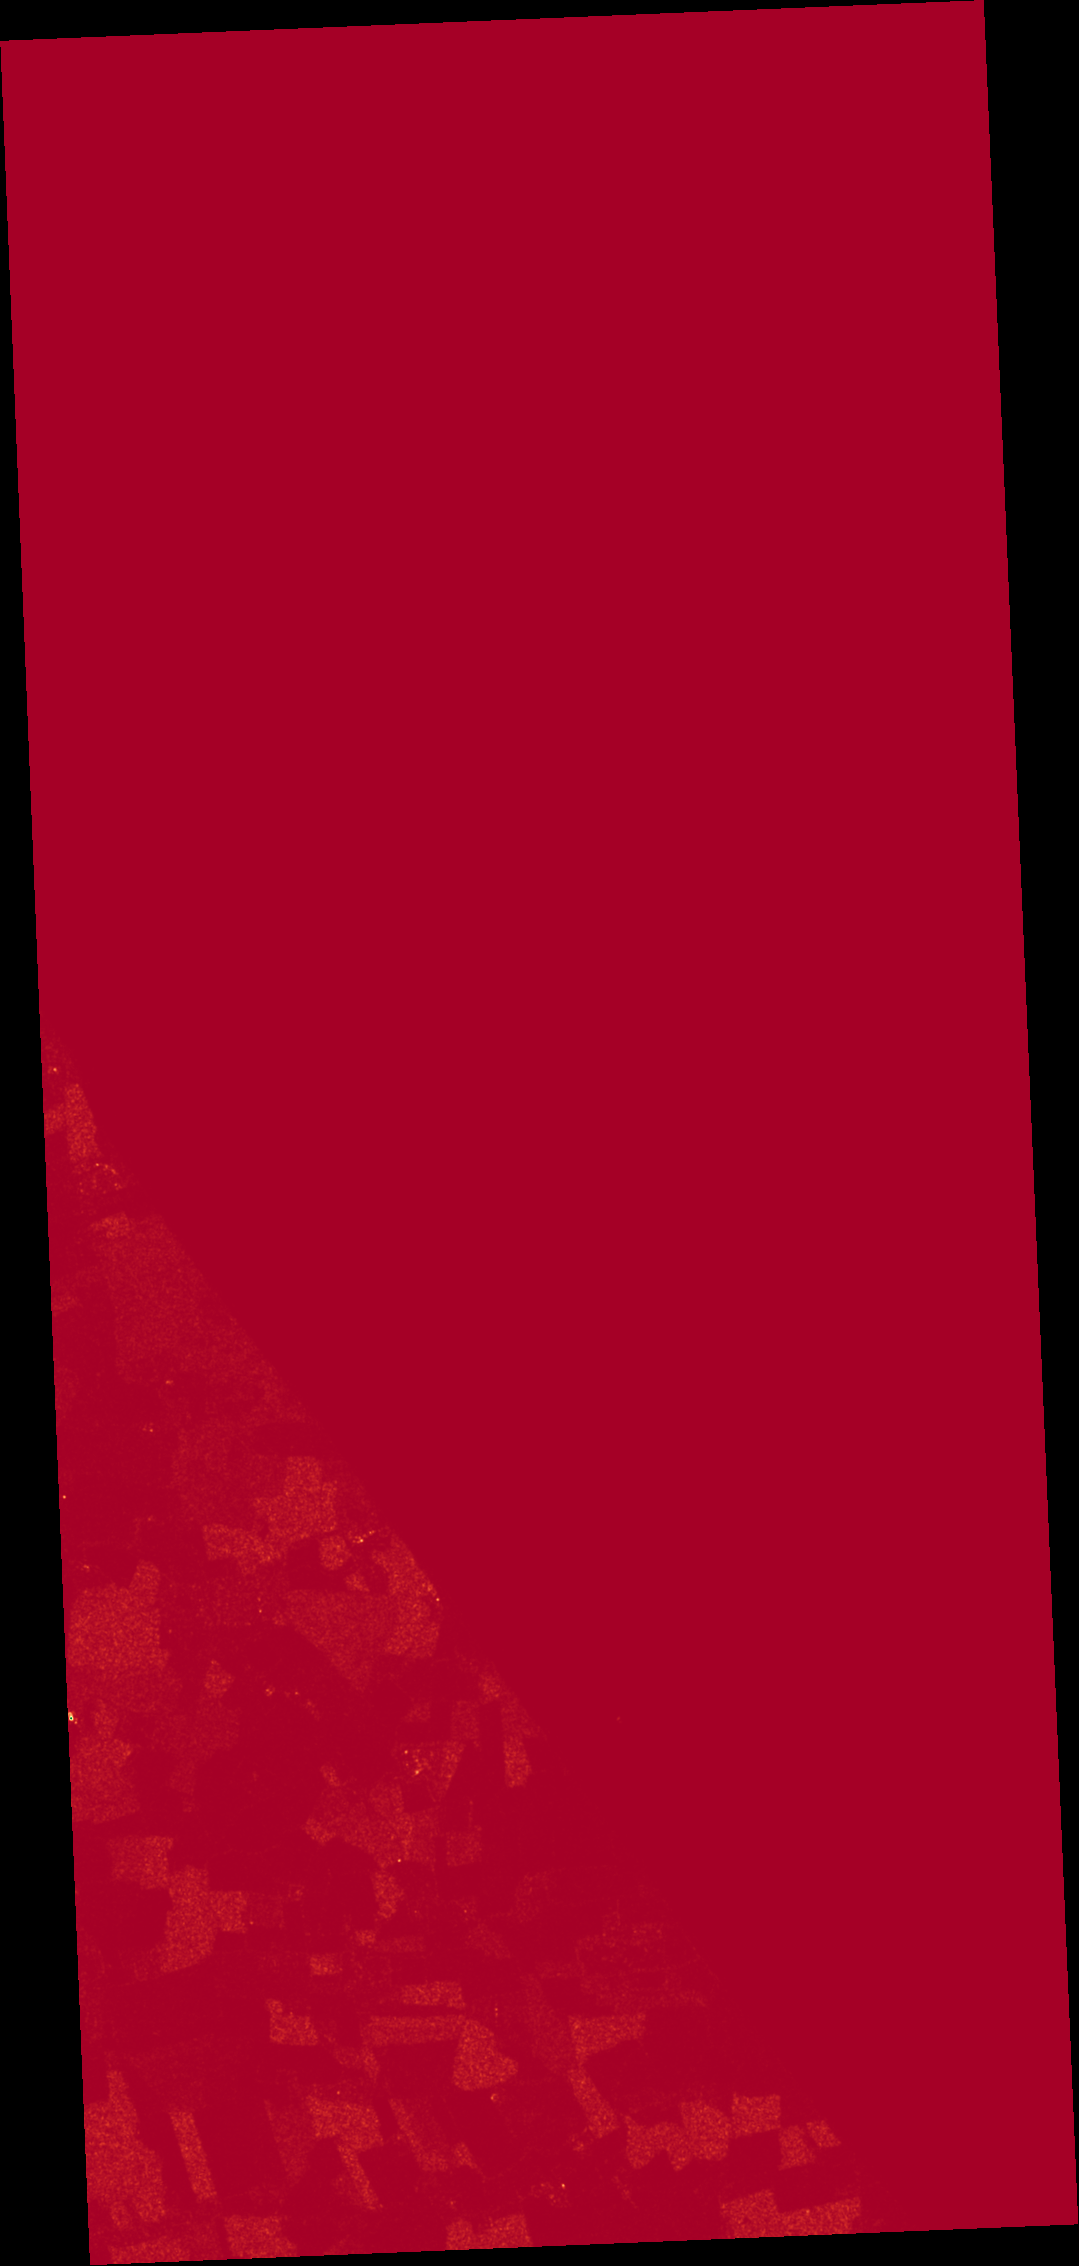

In [13]:
# Tworzenie mapy i dodanie NDVI jako warstwy rastrowej
minx, miny, maxx, maxy = bounds
m = folium.Map(location=[(miny + maxy) / 2, (minx + maxx) / 2], zoom_start=10)
image_overlay = ImageOverlay(
    image=image_url,
    bounds=[[miny, minx], [maxy, maxx]],
    opacity=0.9,
    name="NDVI Layer"
)
image_overlay.add_to(m)

# Dodanie opcji sterowania warstwami
folium.LayerControl().add_to(m)

# Wyświetlenie mapy
m